# Classificação de tópicos por embedding

Importe as bibliotecas necessárias

In [2]:
! pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=58c2145e483ccc7a7356e06602890ff506c93c55f3bc154cbc355b960dfd8e9c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [3]:
# Importing libraries
import regex as re
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from langdetect import detect
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import spacy
import nltk
nltk.download('punkt')
import pandas as pd
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'langdetect'

Separação dos texto por frases

In [ ]:

# Load the spacy model
nlp = spacy.load('en_core_web_sm')

# Load data
data = pd.read_csv('all_ECB_speeches.csv', sep='|')

# Function to detect language of a given text
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = "Unknown"
    return lang

# Apply the language detection function to each text in your DataFrame
data['language'] = data['contents'].apply(detect_language)

# Filter out the texts that are not in English
data = data[data['language'] == 'en']

# Drop null values
data = data.dropna(subset=['speakers', 'contents'])

# Reset index
data = data.reset_index(drop=True)

# Remove introduction
for row in range(data.shape[0]):
    try:
        speech = re.split(" \d+ (January|February|March|April|May|June|July|August|September|October|November|December) \d{4} ", data.loc[row, "contents"])
        data.loc[row, "contents"] = speech[-1]
    except:
        pass

# Split into sentences using spacy
def split_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences

sentences_list = []
for row in range(data.shape[0]):
    text = data.loc[row, "contents"]
    sentences = split_into_sentences(text)
    sentences_list.append(sentences)
data['sentences'] = sentences_list

# Explode the sentences column to have one sentence per row
sentences_df = data.explode('sentences').reset_index(drop=True)

sentences_df.to_csv('sentences_df.csv', index=False)


Lê o dataframe das sentenças e lê as predições feitas manualmente

In [ ]:
sentences_df = pd.read_csv('sentences_df.csv')
my_predictions = pd.read_excel('my_predictions.xlsx')
predictions_adjusted = pd.read_csv('predictions_adjusted.csv')

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
predictions_adjusted = pd.read_csv('predictions_adjusted.csv')
predictions_adjusted = predictions_adjusted.loc[:, ~predictions_adjusted.columns.str.contains('^Unnamed')]
predictions_adjusted = predictions_adjusted.dropna(axis=1, how='all')
predictions_adjusted['Sentiment '].fillna('Unknown', inplace=True)
predictions_adjusted.head()

sid = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    scores = sid.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

predictions_adjusted['predicted_sentiment'] = predictions_adjusted['sentences'].apply(classify_sentiment)

from sklearn.metrics import classification_report

print(classification_report(predictions_adjusted['Sentiment '], predictions_adjusted['predicted_sentiment']))

merged_df['Sentiment'] = merged_df.apply(lambda row: classify_sentiment(row['sentences']) if pd.isna(row['Sentiment ']) else row['Sentiment '], axis=1)


In [111]:
print(predictions_adjusted.head())

   RowNumber                Topic  \
0      10279  Atividade econômica   
1     205159  Atividade econômica   
2       3970               Nenhum   
3     115698               Nenhum   
4      55063  Atividade econômica   

                                           sentences Sentiment   \
0  Here in Estonia, wage growth is currently runn...   Negative   
1  The other half seems to be explained by a sign...   Negative   
2  Since our policies operate with lags, we canno...    Neutral   
3  The preparations are steered by a High-Level G...    Neutral   
4  First, the impact of reshoring and the automat...    Neutral   

  predicted_sentiment  
0            Positive  
1            Positive  
2            Positive  
3             Neutral  
4            Positive  


Coloque as frases classificadas no dataframe de sentenças

In [ ]:
merged_df = sentences_df.merge(predictions_adjusted, on='sentences', how='left')
merged_df['Topic'].fillna('-', inplace=True)
merged_df['Sentiment '].fillna('-', inplace=True)

In [ ]:
merged_df.columns

### Treine o modelo

Crie um embedding para as sentenças classificadas

In [ ]:
df_labeled = merged_df[merged_df['Topic'] != '-']

In [4]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# Carregar o tokenizer e o modelo
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def embed_sentence(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Utilize a média dos embeddings da última camada
    embeddings = outputs.last_hidden_state.mean(dim=1)

    return embeddings.squeeze().numpy()

# Gerar embeddings para todas as sentenças
df_labeled['embeddings'] = df_labeled['sentences'].apply(embed_sentence)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

NameError: name 'df_labeled' is not defined

Separe em treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treino e teste
X = list(df_labeled['embeddings'])
y = df_labeled['Topic']
# Separe 2 de 0.8 para treino e 0.2 para teste em cada tópico
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



Treine o classificador e avalie o conjunto de teste

Precision: A precisão é a proporção de identificações positivas que foram corretamente classificadas. É calculada como o número de verdadeiros positivos dividido pela soma de verdadeiros positivos e falsos positivos.

Sensibilidade ou taxa de verdadeiro positivo: O recall é a proporção de casos positivos reais que foram corretamente identificados pelo modelo.

F1-Score: É a média harmônica entre precisão e recall. É útil quando você deseja balancear precisão e recall. Um F1-Score perfeito é 1.00, o que indica precisão e recall perfeitos.

 Support: Refere-se ao número de ocorrências reais da classe no conjunto de dados especificado.

 Acurácia: É a proporção de previsões corretas, tanto verdadeiros positivos quanto verdadeiros negativos, em relação ao total de casos examinados.

 Macro Average: Calcula a média das métricas precisão, recall, F1-score para cada classe, sem levar em conta o suporte número de instâncias para cada classe.
 Weighted Average: Calcula a média das métricas considerando o suporte de cada classe. Isso significa que as classes com mais instâncias têm mais peso no cálculo da média.

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Treinar o classificador
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Avaliar o classificador
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))


                        precision    recall  f1-score   support

   Atividade econômica       1.00      1.00      1.00         3
Atividade econômica          1.00      1.00      1.00         1
              Inflação       0.00      0.00      0.00         1
                Nenhum       0.96      1.00      0.98        22
    Política monetária       1.00      1.00      1.00         1

              accuracy                           0.96        28
             macro avg       0.79      0.80      0.80        28
          weighted avg       0.93      0.96      0.95        28



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [118]:
from sklearn.linear_model import LogisticRegression

# Treinar o classificador
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Avaliar o classificador
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))


Logistic Regression Classification Report:
                        precision    recall  f1-score   support

   Atividade econômica       1.00      1.00      1.00         3
Atividade econômica          1.00      1.00      1.00         1
              Inflação       0.00      0.00      0.00         1
                Nenhum       0.96      1.00      0.98        22
    Política monetária       1.00      1.00      1.00         1

              accuracy                           0.96        28
             macro avg       0.79      0.80      0.80        28
          weighted avg       0.93      0.96      0.95        28



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
from sklearn.svm import SVC

# Treinar o classificador
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Avaliar o classificador
y_pred_svm = svm_classifier.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Classification Report:
                        precision    recall  f1-score   support

   Atividade econômica       1.00      1.00      1.00         3
Atividade econômica          1.00      1.00      1.00         1
              Inflação       0.00      0.00      0.00         1
                Nenhum       0.96      1.00      0.98        22
    Política monetária       1.00      1.00      1.00         1

              accuracy                           0.96        28
             macro avg       0.79      0.80      0.80        28
          weighted avg       0.93      0.96      0.95        28



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifique as sentenças não rotuladas

In [120]:
# Filtrar sentenças não rotuladas e gerar embeddings para um intervalo de sentenças na Christine Lagarde
mask = (merged_df['Topic'] == '-') & (merged_df['speakers'] == 'Christine Lagarde')
df_unlabeled = merged_df[mask]
# Gerar embeddings para sentenças não rotuladas
df_unlabeled['embeddings'] = df_unlabeled['sentences'].apply(embed_sentence)
print("Embeddings gerados para sentenças não rotuladas")
# Prever rótulos para sentenças não rotuladas
X_unlabeled = list(df_unlabeled['embeddings'])
y_unlabeled = classifier.predict(X_unlabeled)
df_unlabeled['Topic'] = y_unlabeled
print("Rótulos previstos para sentenças não rotuladas")
# Ver as predições
print(df_unlabeled[['sentences', 'Topic']])


<ipython-input-120-f8b8c3530804>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['embeddings'] = df_unlabeled['sentences'].apply(embed_sentence)


Embeddings gerados para sentenças não rotuladas
Rótulos previstos para sentenças não rotuladas
                                               sentences                Topic
0      As we approach the end of this legislative ter...               Nenhum
1      Building on this collaborative spirit, today’s...               Nenhum
2      Let me start by outlining the current state of...               Nenhum
3      I will then focus on the need for a common Eur...               Nenhum
4      Bringing inflation back to target in a challen...  Atividade econômica
...                                                  ...                  ...
73464  [2]According to the latest Eurobarometer surve...               Nenhum
73465      [3]Schäuble-Lamers Paper, 1 September 1994.                 Nenhum
73466  [4]Interview with the Financial Times, 6 Octob...               Nenhum
73467  [5]Interview with the Financial Times, 22 Marc...               Nenhum
73468  [6]Interview with Bild am Sonntag, 3 Oct

<ipython-input-120-f8b8c3530804>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['Topic'] = y_unlabeled


Filtre os dados da Christine Lagarde  e classifique-os

In [121]:
filtered_df = df_unlabeled[df_unlabeled['Topic'] != 'Nenhum']

# Exibir o resultado
print(filtered_df[['sentences', 'Topic']])

                                               sentences                Topic
4      Bringing inflation back to target in a challen...  Atividade econômica
5      Having peaked at 10.6% in October 2022, inflat...  Atividade econômica
6      After expanding by 3.4% in 2022, euro area eco...  Atividade econômica
11     Unemployment stood at a historical low of 6.4%...  Atividade econômica
12      Inflation decreased slightly to 2.8% in January.  Atividade econômica
...                                                  ...                  ...
72529  Public investment in the euro area remains som...  Atividade econômica
72530  The share of productive expenditure in total p...  Atividade econômica
72537  This is also reflected in differences in total...  Atividade econômica
72547  But on the other hand, prioritising risk reduc...  Atividade econômica
72563  [3]Since the onset of the financial crisis, do...  Atividade econômica

[1363 rows x 2 columns]


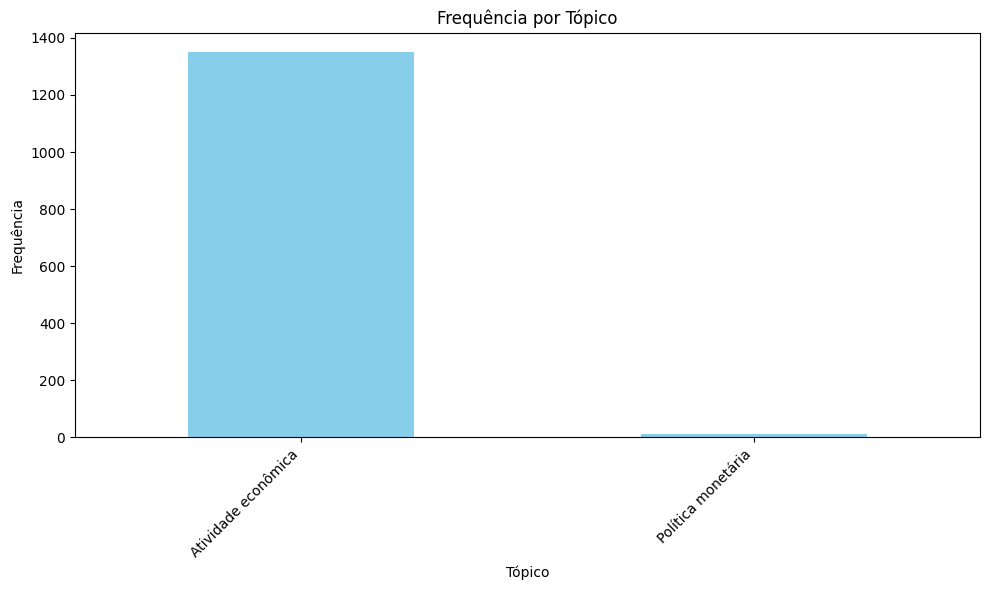

In [122]:
topic_counts = filtered_df['Topic'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))  # Ajusta o tamanho da figura
topic_counts.plot(kind='bar', color='skyblue')  # Gera um gráfico de barras
plt.title('Frequência por Tópico')  # Título do gráfico
plt.xlabel('Tópico')  # Rótulo do eixo X
plt.ylabel('Frequência')  # Rótulo do eixo Y
plt.xticks(rotation=45, ha='right')  # Rotação dos rótulos no eixo X para melhor visualização
plt.tight_layout()  # Ajusta automaticamente os subplots para dar espaço aos rótulos
plt.show()

In [2]:
# Junte os dados rotulados e não rotulados da Christine Lagarde
# Filtrar sentenças rotuladas da Christine Lagarde
mask = merged_df['speakers'] == 'Christine Lagarde'
df_lagarde = merged_df[mask]
# Juntar dados rotulados e não rotulados
df_lagarde = pd.concat([df_lagarde, df_unlabeled])

NameError: name 'merged_df' is not defined

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Primeiro, calcular a matriz de contagem cruzada
pivot_table = pd.crosstab(df_lagarde['Topic'], df_lagarde['Sentiment '])

# Agora, plotar o heatmap usando seaborn
plt.figure(figsize=(12, 8))  # Define o tamanho da figura
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='g')  # Cria o heatmap
plt.title('Heatmap de Tópico por Sentimento')  # Título do gráfico
plt.xlabel('Sentimento')  # Rótulo do eixo X
plt.ylabel('Tópico')  # Rótulo do eixo Y
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor visualização
plt.yticks(rotation=0)  # Mantém os rótulos do eixo Y na posição


NameError: name 'df_lagarde' is not defined

In [124]:
df_lagarde

,date,speakers,title,subtitle,contents,language,sentences,RowNumber,Topic,Sentiment,predicted_sentiment,embeddings
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,As we approach the end of this legislative ter...,NaN,-,-,NaN,NaN
1,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,"Building on this collaborative spirit, today’s...",NaN,-,-,NaN,NaN
2,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,Let me start by outlining the current state of...,NaN,-,-,NaN,NaN
3,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,I will then focus on the need for a common Eur...,NaN,-,-,NaN,NaN
4,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,Bringing inflation back to target in a challen...,NaN,-,-,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
73464,2019-11-04,Christine Lagarde,Laudatory speech,"Laudatory speech by Christine Lagarde, Preside...",The English philosopher John Stuart Mill once ...,en,[2]According to the latest Eurobarometer surve...,NaN,Nenhum,-,NaN,"[-0.16880372, -0.33953473, 0.6681823, 0.153615..."
73465,2019-11-04,Christine Lagarde,Laudatory speech,"Laudatory speech by Christine Lagarde, Preside...",The English philosopher John Stuart Mill once ...,en,"[3]Schäuble-Lamers Paper, 1 September 1994.",NaN,Nenhum,-,NaN,"[-0.35799775, -0.06412062, 0.08841011, -0.2575..."
73466,2019-11-04,Christine Lagarde,Laudatory speech,"Laudatory speech by Christine Lagarde, Preside...",The English philosopher John Stuart Mill once ...,en,"[4]Interview with the Financial Times, 6 Octob...",NaN,Nenhum,-,NaN,"[-0.16104476, -0.34534162, 0.31121168, -0.2704..."
73467,2019-11-04,Christine Lagarde,Laudatory speech,"Laudatory speech by Christine Lagarde, Preside...",The English philosopher John Stuart Mill once ...,en,"[5]Interview with the Financial Times, 22 Marc...",NaN,Nenhum,-,NaN,"[-0.13673006, -0.42101076, 0.4149473, -0.22641..."
